# IMPORT

In [29]:
import os.path as osp
import glob
import sys
import torch
import os
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import numpy as np
import time
from matplotlib import pyplot as plt
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
import lpips
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import cv2
from FinalModels.ESRGAN.model import ESRGAN


# Initialize device and model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ESRGAN(model_path=model_path, device=device)

model = ESRGAN(model_path='../FinalModels/ESRGAN/model/RRDB_ESRGAN_x4.pth', device=device)

# Folder path for test images
folder_path = "d:\\workspace\\ThesisProject\\TESTS\\images\\LR"



# FUNCTIONS

In [56]:


def perform_super_resolution(image_path, model, device):
    """Performs super-resolution on an input image."""
    model.to(device)
    start = time.time()
    hr_image = preprocess_image(image_path).to(device)
    # original = hr_image
    lr_image = hr_image
    bicubic_image = F.interpolate(hr_image, size=(224, 224), mode='bicubic', align_corners=False)

    modes = {
        "Bilinear": F.interpolate(hr_image, size=(224, 224), mode='bilinear', align_corners=False),
        "Nearest": F.interpolate(hr_image, size=(224, 224), mode='nearest'),
        "Bicubic": F.interpolate(hr_image, size=(224, 224), mode='bicubic', align_corners=False),
        "None" : F.interpolate(hr_image, size=(224, 224)),
        "Exact": F.interpolate(hr_image, size=(224, 224), mode='nearest-exact')
    }
    
    with torch.no_grad():
        enhanced_image = model(modes['Bicubic'])
    enhanced_image = F.interpolate(enhanced_image, size=(224, 224), mode='bilinear', align_corners=False)
    print(f"Time taken: {time.time() - start:.2f} seconds: enhanced shape: {enhanced_image.shape}, hr shape: {hr_image.shape}, bicubic shape: {bicubic_image.shape}, lr shape: {lr_image.shape}")
    # return enhanced_image, modes
    return hr_image, bicubic_image, enhanced_image, modes

def perform_super_resolution2(image_path, model, device):
    """Performs super-resolution on an input image."""
    model.to(device)
    start = time.time()
    hr_image = preprocess_image(image_path).to(device)
    hr_image = F.interpolate(hr_image, size=(896, 896), mode='bicubic', align_corners=False) # with interpolation
    lr_image = F.interpolate(hr_image, size=(224, 224), mode='bicubic', align_corners=False)
    bicubic_image = F.interpolate(lr_image, size=(896, 896), mode='bicubic', align_corners=False)

    with torch.no_grad():
        enhanced_image = model(lr_image)
    print(f"Time taken: {time.time() - start:.2f} seconds: enhanced shape: {enhanced_image.shape}, hr shape: {hr_image.shape}, bicubic shape: {bicubic_image.shape}, lr shape: {lr_image.shape}")
    # return enhanced_image, modes
    return hr_image, bicubic_image, enhanced_image


lpips_loss_fn = lpips.LPIPS(net='alex').to(device)

def evaluate_performance(hr_image, sr_image):
    """
    Evaluate the performance of super-resolution using multiple metrics.
    
    Parameters:
    - hr_image (torch.Tensor): High-resolution ground truth image (CxHxW, range [0,1])
    - sr_image (torch.Tensor): Super-resolved image (CxHxW, range [0,1])

    Returns:
    - metrics (dict): Dictionary containing PSNR, SSIM, LPIPS, and MOS
    """
    # Ensure images have the same spatial resolution
    sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bicubic', align_corners=False)
    if hr_image.shape != sr_image.shape:
        print(f"Shape mismatch: HR {hr_image.shape}, SR {sr_image.shape}")
        return None  

    # Convert to single image if batch exists: [B, C, H, W] -> [C, H, W]
    if len(hr_image.shape) == 4:
        hr_image = hr_image.squeeze(0)  # Remove batch dim
        sr_image = sr_image.squeeze(0)

    hr_image = torch.clamp(hr_image, 0, 1)
    sr_image = torch.clamp(sr_image, 0, 1)

    # Convert PyTorch tensors to NumPy
    hr_np = hr_image.permute(1, 2, 0).cpu().numpy()  # CxHxW -> HxWxC
    sr_np = sr_image.permute(1, 2, 0).cpu().numpy()

    # PSNR calculation
    mse = F.mse_loss(sr_image, hr_image)
    psnr = 10 * torch.log10(1.0 / mse) if mse > 0 else float('inf')


    # Compute SSIM
    ssim_score = ssim(hr_np, sr_np, data_range=hr_np.max() - hr_np.min(), channel_axis=2)

    # Compute LPIPS (Convert tensors to 4D batch format)
    lpips_hr = 2 * hr_image - 1  # Convert [0, 1] -> [-1, 1]
    lpips_sr = 2 * sr_image - 1  # Convert [0, 1] -> [-1, 1]
    lpips_score = lpips_loss_fn(lpips_sr.unsqueeze(0), lpips_hr.unsqueeze(0)).item()

    # Simulated MOS Score (Optional: Replace with user study results)
    mos_score = (5 * (1 - lpips_score))  # Assumes LPIPS ~1 means worst, LPIPS ~0 means best

    # Return all metrics as a dictionary
    metrics = {
        "PSNR": psnr.item(),
        "SSIM": ssim_score,
        "LPIPS": lpips_score,
        "MOS (estimated)": mos_score
    }

    return metrics

def compute_ssim(hr_image, sr_image):
    return ssim(hr_image, sr_image, data_range=hr_image.max() - hr_image.min(), multichannel=True)

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()
    return transform(img).unsqueeze(0)  # Add batch dimension


def downscale_image(hr_image, scale=4):
    lr_size = (hr_image.size(2) // scale, hr_image.size(3) // scale)
    lr_image = F.interpolate(hr_image, size=lr_size, mode='bicubic', align_corners=False)
    return lr_image

# lpips_loss_fn = lpips.LPIPS(net='alex').to(device)

def save_image_esrgan(image, save_path, device, filename):
    """Saves the image tensor to a file after interpolation and conversion, running on GPU if needed."""
    
    image = image.to(device)
    image = F.interpolate(image, size=(224,224), mode='bilinear', align_corners=False)
    # image = F.interpolate(image, (size, size), mode='bicubic', align_corners=False).squeeze(0)
    
    # Convert from (C, H, W) to (H, W, C)
    image = image.squeeze().permute(1, 2, 0)
    
    # Move tensor to CPU before converting to NumPy
    image = image.cpu().numpy()
    
    image = np.clip(image * 255, 0, 255).astype(np.uint8)
    
    print("Shape before save:", )
    
    pil_image = Image.fromarray(image)
    try:
        pil_image.save(os.path.join(save_path, filename + '.png'), format='PNG')  
        print(f"Saved {filename} Shape: {image.shape} at {save_path}")
    except Exception as e:
        print(f"Error saving {filename}: {e}")

def compare_images(hr_image, lr_image, sr_image, psnr):
    """Compare the images by displaying them and printing PSNR."""
    sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bicubic', align_corners=False)
    def process_image(img):
        if isinstance(img, torch.Tensor):
            img = img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert (3, H, W) to (H, W, 3)
        else:
            img = np.squeeze(img)  
            if img.ndim == 3 and img.shape[0] in [1, 3]:  # If channel-first, convert to channel-last
                img = np.transpose(img, (1, 2, 0))
        return img
    lr_image = F.interpolate(lr_image, size=hr_image.shape[2:], mode='bicubic', align_corners=False)
    print('shape of hr_image:', hr_image.shape, 'shape of bicubic:', lr_image.shape, 'shape of sr_image:', sr_image.shape)
    hr_image = hr_image.cpu().numpy() if isinstance(hr_image, torch.Tensor) else hr_image
    lr_image = lr_image.cpu().numpy() if isinstance(lr_image, torch.Tensor) else lr_image
    sr_image = sr_image.cpu().numpy() if isinstance(sr_image, torch.Tensor) else sr_image
    
    hr_image = np.clip(hr_image, 0, 1)
    lr_image = np.clip(lr_image, 0, 1)
    sr_image = np.clip(sr_image, 0, 1)

    hr_image = process_image(hr_image)
    lr_image = process_image(lr_image)
    sr_image = process_image(sr_image)

    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axes = plt.subplots(1, 3)
    fig.tight_layout()

    # Plot Original Image
    plt.subplot(131)
    plot_image(hr_image, title="Original")
    
    # Plot Low-Resolution Image
    plt.subplot(132)
    plot_image(lr_image, title="x4 Bicubic")
    
    # Plot Super-Resolved Image
    plt.subplot(133)
    plot_image(sr_image, title="Super Resolution")
    
    plt.show(block=False)
    

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: d:\workspace\ThesisProject\venv\Lib\site-packages\lpips\weights\v0.1\alex.pth


# CASE 1: BICUBIC ONLY

In [17]:

idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output  =  perform_bicubic(path, model, device)

    metrics = evaluate_performance(original, output)

    print(metrics)


1 1
Time taken: 0.04 seconds
{'PSNR': 38.66877746582031, 'SSIM': np.float32(0.9931086), 'LPIPS': 0.007598179392516613, 'MOS (estimated)': 4.962009103037417}
2 Balistapus Undulatus-notenhanced
Time taken: 0.00 seconds
{'PSNR': 64.32012939453125, 'SSIM': np.float32(0.999965), 'LPIPS': 1.3819768355460837e-05, 'MOS (estimated)': 4.999930901158223}
3 car
Time taken: 0.01 seconds
{'PSNR': 52.652469635009766, 'SSIM': np.float32(0.99872166), 'LPIPS': 0.0006605084636248648, 'MOS (estimated)': 4.996697457681876}
4 Chaetodon Trifascialis
Time taken: 0.00 seconds
{'PSNR': 39.575923919677734, 'SSIM': np.float32(0.99313474), 'LPIPS': 0.0053914980962872505, 'MOS (estimated)': 4.973042509518564}
5 fish_000001229596_03681
Time taken: 0.00 seconds
{'PSNR': 68.9134292602539, 'SSIM': np.float32(0.99998254), 'LPIPS': 4.660903869080357e-06, 'MOS (estimated)': 4.999976695480655}
6 fish_000013099594_03543
Time taken: 0.00 seconds
{'PSNR': 36.04613494873047, 'SSIM': np.float32(0.9868691), 'LPIPS': 0.0284592267

# CASE 2: NEAREST

In [50]:

idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Nearest'])

    lr_image = downscale_image(original)


1 1
Time taken: 0.56 seconds
=============PSNR Achieved: 30.978840==============
2 Balistapus Undulatus-notenhanced
Time taken: 0.40 seconds
=============PSNR Achieved: 51.352306==============
3 car
Time taken: 0.38 seconds
=============PSNR Achieved: 34.236904==============
4 Chaetodon Trifascialis
Time taken: 0.37 seconds
=============PSNR Achieved: 27.995262==============
5 fish_000001229596_03681
Time taken: 0.38 seconds
PSNR: Infinite (identical images)
6 fish_000013099594_03543
Time taken: 0.37 seconds
=============PSNR Achieved: 24.793503==============
7 fish_000026690001_02685
Time taken: 0.38 seconds
PSNR: Infinite (identical images)
8 fish_000065789596_04756
Time taken: 0.38 seconds
PSNR: Infinite (identical images)
9 notenhanced
Time taken: 0.37 seconds
=============PSNR Achieved: 28.323526==============
10 notenhanced2
Time taken: 0.37 seconds
=============PSNR Achieved: 43.786999==============
11 notenhanced3
Time taken: 0.38 seconds
=============PSNR Achieved: 50.236275==

# CASE 3: BILINEAR ONLY

In [51]:
idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Bilinear'])

    lr_image = downscale_image(original)


1 1
Time taken: 0.77 seconds
=============PSNR Achieved: 39.477783==============
2 Balistapus Undulatus-notenhanced
Time taken: 0.38 seconds
=============PSNR Achieved: 44.631348==============
3 car
Time taken: 0.38 seconds
=============PSNR Achieved: 45.441269==============
4 Chaetodon Trifascialis
Time taken: 0.38 seconds
=============PSNR Achieved: 33.924568==============
5 fish_000001229596_03681
Time taken: 0.38 seconds
=============PSNR Achieved: 50.188805==============
6 fish_000013099594_03543
Time taken: 0.38 seconds
=============PSNR Achieved: 31.119644==============
7 fish_000026690001_02685
Time taken: 0.37 seconds
=============PSNR Achieved: 48.121094==============
8 fish_000065789596_04756
Time taken: 0.38 seconds
=============PSNR Achieved: 48.775333==============
9 notenhanced
Time taken: 0.38 seconds
=============PSNR Achieved: 35.747143==============
10 notenhanced2
Time taken: 0.38 seconds
=============PSNR Achieved: 35.717346==============
11 notenhanced3
Time taken

# CASE 4: Nearest Exact

In [3]:
idx = 0
for path in glob.glob(folder_path + "/*"):
    start = time.time()
    
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, output, resized_modes  =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, resized_modes['Exact'])

    lr_image = downscale_image(original)


1 1
Time taken: 0.70 seconds
=============PSNR Achieved: 38.519455==============
2 Balistapus Undulatus-notenhanced
Time taken: 0.44 seconds
PSNR: Infinite (identical images)
3 car
Time taken: 0.44 seconds
=============PSNR Achieved: 43.102688==============
4 Chaetodon Trifascialis
Time taken: 0.43 seconds
=============PSNR Achieved: 33.005253==============
5 fish_000001229596_03681
Time taken: 0.44 seconds
PSNR: Infinite (identical images)
6 fish_000013099594_03543
Time taken: 1.87 seconds
=============PSNR Achieved: 30.335114==============
7 fish_000026690001_02685
Time taken: 2.11 seconds
PSNR: Infinite (identical images)
8 fish_000065789596_04756
Time taken: 1.99 seconds
PSNR: Infinite (identical images)
9 notenhanced
Time taken: 1.78 seconds
=============PSNR Achieved: 35.085888==============
10 notenhanced2
Time taken: 1.80 seconds
PSNR: Infinite (identical images)
11 notenhanced3
Time taken: 2.05 seconds
=============PSNR Achieved: 54.706020==============
12 SAMPLE_LUTJANUS
Time

# CASE 5: BICUBIC + ESRGAN

In [57]:

idx = 0
for path in glob.glob(folder_path + "/*"):
    # for fish_class in glob.glob(path + "/*"):
        
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)

    original, bicubic, output, mode =  perform_super_resolution(path, model, device)

    psnr = evaluate_performance(original, output)
    print('ESRGAN:', psnr)
    psnr = evaluate_performance(original, bicubic)
    print('BICUBIC:', psnr)
    # compare_images(original, bicubic, output, psnr)

     # IF SAVE IMAGE NO NEED
    # save_image_esrgan(bicubic, "images/HR", device, f'{idx}-cubic-{base}')
    # save_image_esrgan(output, "images/HR", device, f'{idx}-esr-{base}') 




1 Abudefduf Vaigiensis
Time taken: 0.68 seconds: enhanced shape: torch.Size([1, 3, 224, 224]), hr shape: torch.Size([1, 3, 52, 67]), bicubic shape: torch.Size([1, 3, 224, 224]), lr shape: torch.Size([1, 3, 52, 67])
ESRGAN: {'PSNR': 45.14577865600586, 'SSIM': np.float32(0.99970245), 'LPIPS': 0.00011898877710336819, 'MOS (estimated)': 4.999405056114483}
BICUBIC: {'PSNR': 67.66184997558594, 'SSIM': np.float32(0.9999881), 'LPIPS': 6.819414466008311e-06, 'MOS (estimated)': 4.99996590292767}
2 Acanthurus Nigrofuscus
Time taken: 0.39 seconds: enhanced shape: torch.Size([1, 3, 224, 224]), hr shape: torch.Size([1, 3, 63, 67]), bicubic shape: torch.Size([1, 3, 224, 224]), lr shape: torch.Size([1, 3, 63, 67])
ESRGAN: {'PSNR': 44.961395263671875, 'SSIM': np.float32(0.9995838), 'LPIPS': 0.0005363385425880551, 'MOS (estimated)': 4.99731830728706}
BICUBIC: {'PSNR': 70.85490417480469, 'SSIM': np.float32(0.99998546), 'LPIPS': 1.601500844117254e-05, 'MOS (estimated)': 4.999919924957794}
3 Balistapus Und

# PLOTTING THE DIFFERENCE

**ESRGAN + BICUBIC**

1: Abudefduf Vaigiensis
Time taken: 0.64 seconds: enhanced shape: torch.Size([1, 3, 896, 896]), hr shape: torch.Size([1, 3, 896, 896]), bicubic shape: torch.Size([1, 3, 896, 896]), lr shape: torch.Size([1, 3, 224, 224])
ESRGAN:  {'PSNR': 45.062583923339844, 'SSIM': np.float32(0.99951106), 'LPIPS': 0.0006786781596019864, 'MOS (estimated)': 4.99660660920199}
BICUBIC:  {'PSNR': 64.27420043945312, 'SSIM': np.float32(0.9997948), 'LPIPS': 0.0002855940256267786, 'MOS (estimated)': 4.998572029871866}
shape of hr_image: torch.Size([1, 3, 896, 896]) shape of bicubic: torch.Size([1, 3, 896, 896]) shape of sr_image: torch.Size([1, 3, 896, 896])


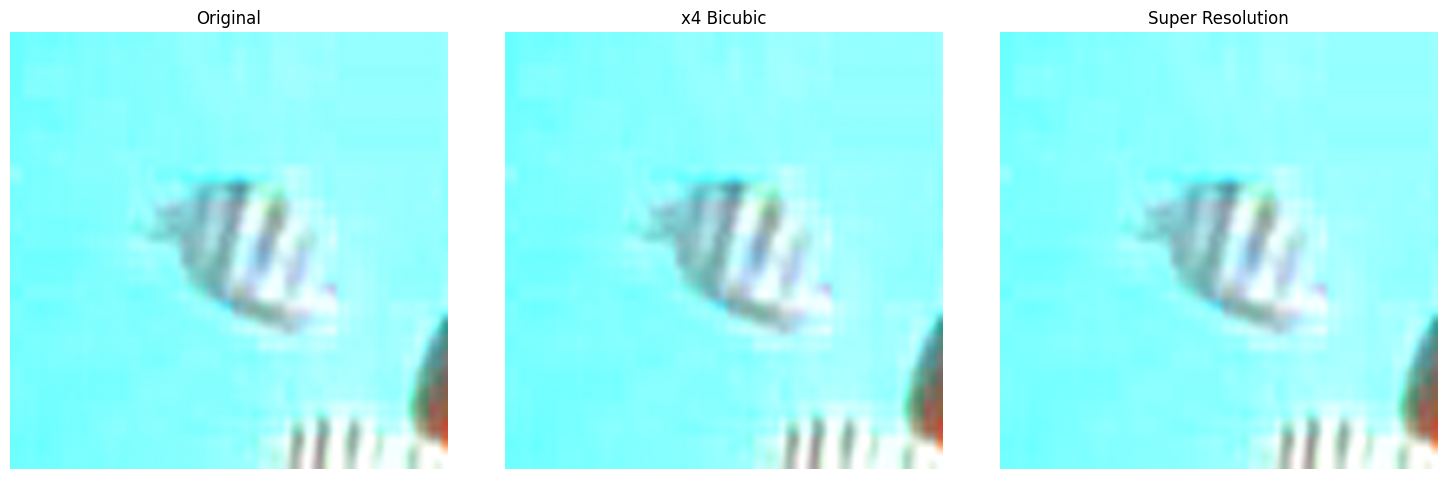

2: Acanthurus Nigrofuscus
Time taken: 0.38 seconds: enhanced shape: torch.Size([1, 3, 896, 896]), hr shape: torch.Size([1, 3, 896, 896]), bicubic shape: torch.Size([1, 3, 896, 896]), lr shape: torch.Size([1, 3, 224, 224])
ESRGAN:  {'PSNR': 44.90398406982422, 'SSIM': np.float32(0.9995144), 'LPIPS': 0.0021942066960036755, 'MOS (estimated)': 4.989028966519982}
BICUBIC:  {'PSNR': 65.73729705810547, 'SSIM': np.float32(0.99973613), 'LPIPS': 0.00015675071335863322, 'MOS (estimated)': 4.999216246433207}
shape of hr_image: torch.Size([1, 3, 896, 896]) shape of bicubic: torch.Size([1, 3, 896, 896]) shape of sr_image: torch.Size([1, 3, 896, 896])


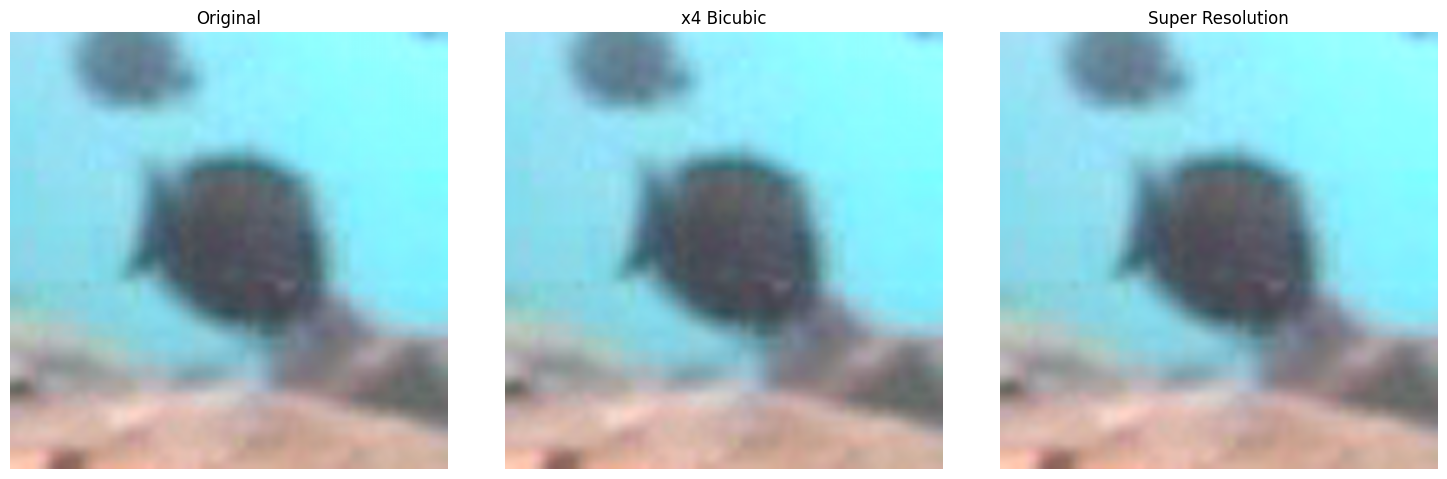

3: Balistapus Undulatus
Time taken: 0.38 seconds: enhanced shape: torch.Size([1, 3, 896, 896]), hr shape: torch.Size([1, 3, 896, 896]), bicubic shape: torch.Size([1, 3, 896, 896]), lr shape: torch.Size([1, 3, 224, 224])
ESRGAN:  {'PSNR': 45.67347717285156, 'SSIM': np.float32(0.99914694), 'LPIPS': 0.0019498229958117008, 'MOS (estimated)': 4.9902508850209415}
BICUBIC:  {'PSNR': 58.86029052734375, 'SSIM': np.float32(0.99954313), 'LPIPS': 0.0007909321575425565, 'MOS (estimated)': 4.996045339212287}
shape of hr_image: torch.Size([1, 3, 896, 896]) shape of bicubic: torch.Size([1, 3, 896, 896]) shape of sr_image: torch.Size([1, 3, 896, 896])


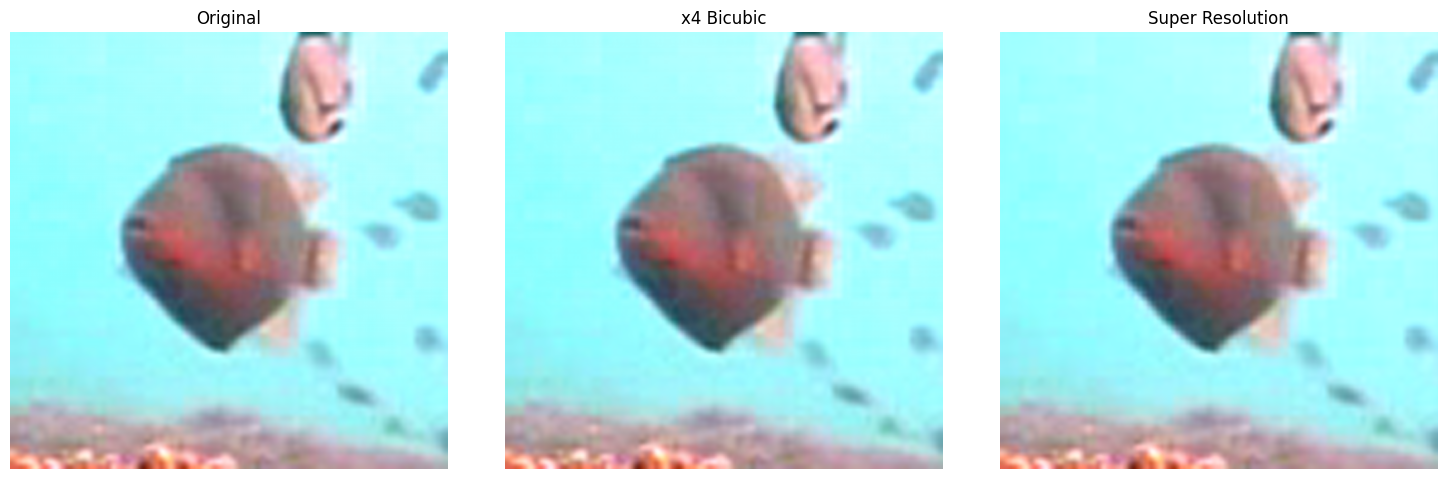

4: Canthigaster Valentini
Time taken: 0.37 seconds: enhanced shape: torch.Size([1, 3, 896, 896]), hr shape: torch.Size([1, 3, 896, 896]), bicubic shape: torch.Size([1, 3, 896, 896]), lr shape: torch.Size([1, 3, 224, 224])
ESRGAN:  {'PSNR': 44.63796615600586, 'SSIM': np.float32(0.99362487), 'LPIPS': 0.005080556496977806, 'MOS (estimated)': 4.974597217515111}
BICUBIC:  {'PSNR': 53.88490295410156, 'SSIM': np.float32(0.9988809), 'LPIPS': 0.0032870774157345295, 'MOS (estimated)': 4.983564612921327}
shape of hr_image: torch.Size([1, 3, 896, 896]) shape of bicubic: torch.Size([1, 3, 896, 896]) shape of sr_image: torch.Size([1, 3, 896, 896])


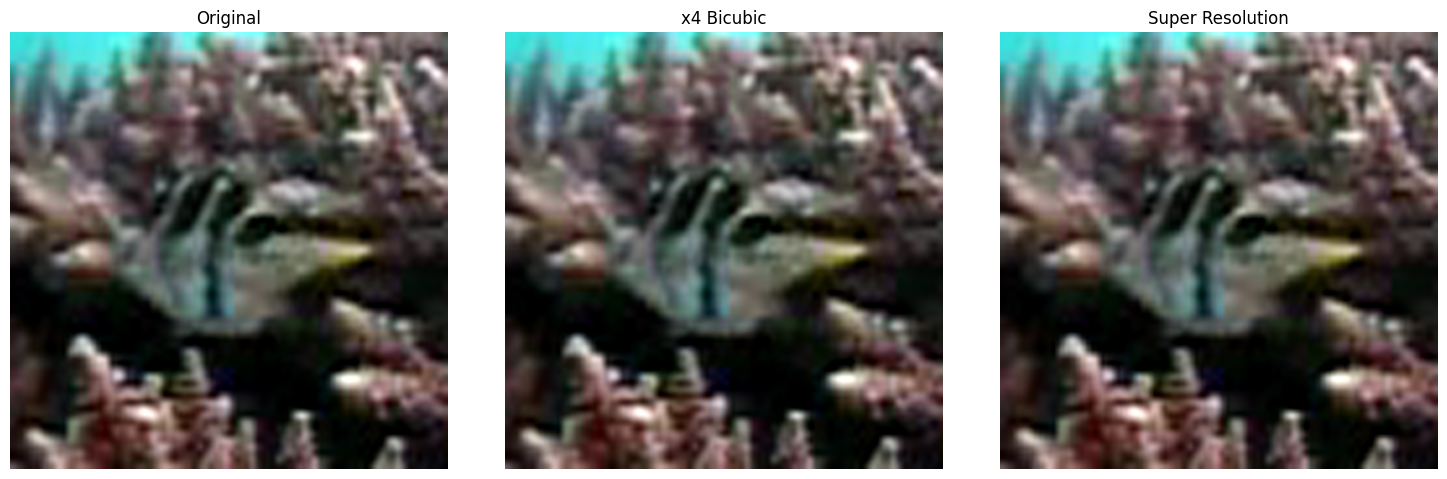

5: Chaetodon Trifascialis
Time taken: 0.38 seconds: enhanced shape: torch.Size([1, 3, 896, 896]), hr shape: torch.Size([1, 3, 896, 896]), bicubic shape: torch.Size([1, 3, 896, 896]), lr shape: torch.Size([1, 3, 224, 224])
ESRGAN:  {'PSNR': 32.0341682434082, 'SSIM': np.float32(0.95723397), 'LPIPS': 0.08546856045722961, 'MOS (estimated)': 4.572657197713852}
BICUBIC:  {'PSNR': 42.529911041259766, 'SSIM': np.float32(0.9928813), 'LPIPS': 0.005863170605152845, 'MOS (estimated)': 4.970684146974236}
shape of hr_image: torch.Size([1, 3, 896, 896]) shape of bicubic: torch.Size([1, 3, 896, 896]) shape of sr_image: torch.Size([1, 3, 896, 896])


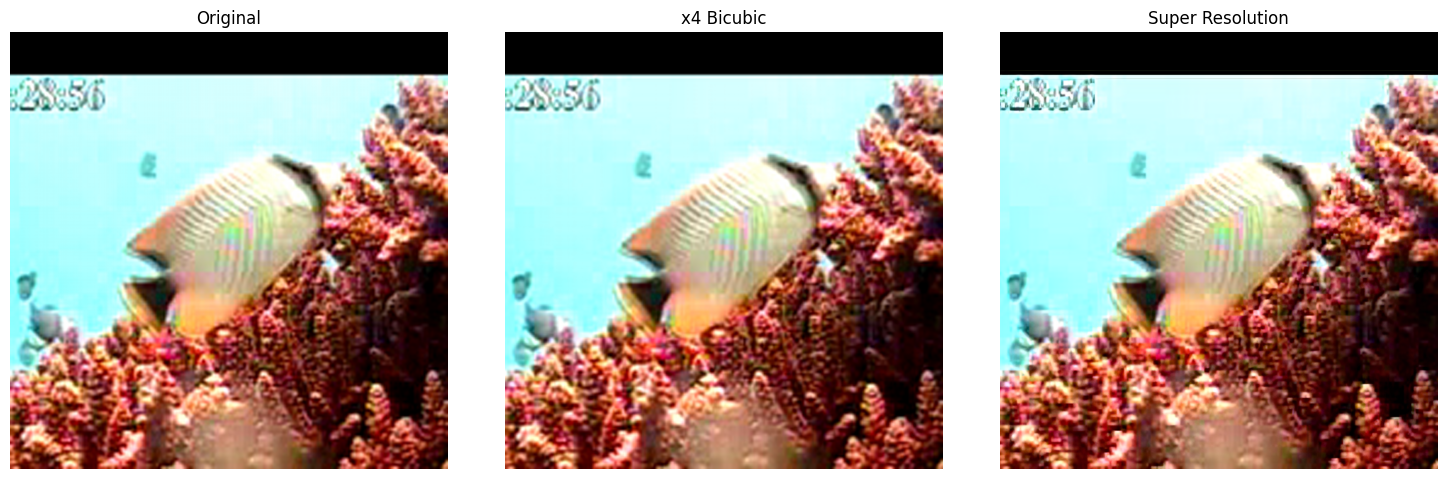

6: Hemigymnus Fasciatus
Time taken: 0.38 seconds: enhanced shape: torch.Size([1, 3, 896, 896]), hr shape: torch.Size([1, 3, 896, 896]), bicubic shape: torch.Size([1, 3, 896, 896]), lr shape: torch.Size([1, 3, 224, 224])
ESRGAN:  {'PSNR': 45.05396270751953, 'SSIM': np.float32(0.99625874), 'LPIPS': 0.010723112151026726, 'MOS (estimated)': 4.946384439244866}
BICUBIC:  {'PSNR': 53.21786880493164, 'SSIM': np.float32(0.9992897), 'LPIPS': 0.002010108670219779, 'MOS (estimated)': 4.989949456648901}
shape of hr_image: torch.Size([1, 3, 896, 896]) shape of bicubic: torch.Size([1, 3, 896, 896]) shape of sr_image: torch.Size([1, 3, 896, 896])


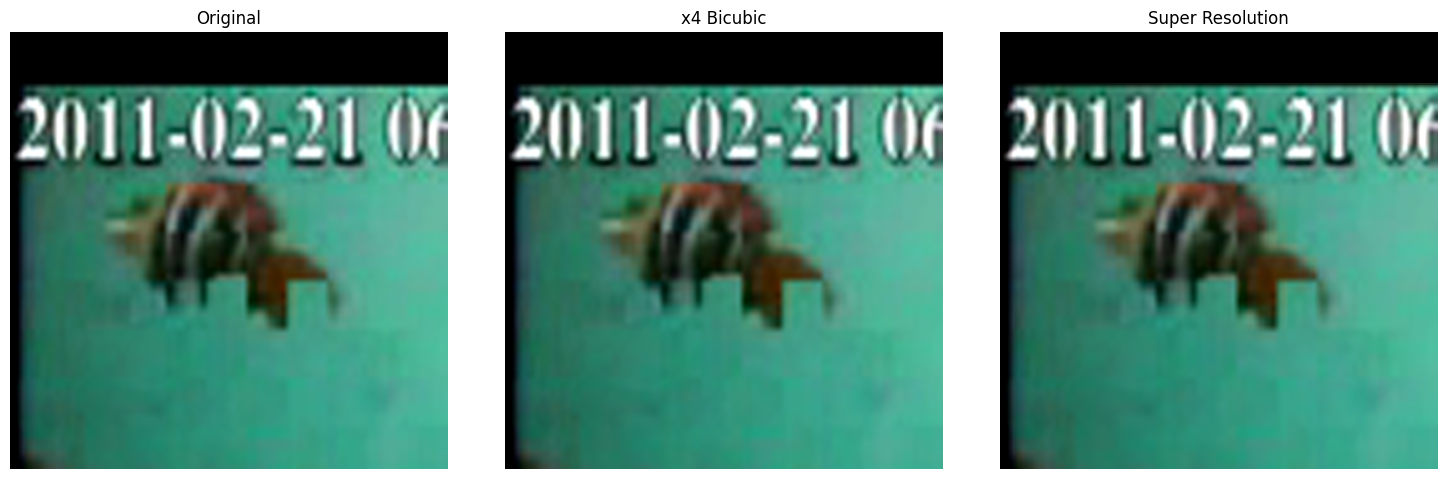

7: Hemigymnus Melapterus
Time taken: 0.37 seconds: enhanced shape: torch.Size([1, 3, 896, 896]), hr shape: torch.Size([1, 3, 896, 896]), bicubic shape: torch.Size([1, 3, 896, 896]), lr shape: torch.Size([1, 3, 224, 224])


KeyboardInterrupt: 

In [58]:
total_psnr_esrgan = 0
total_psnr_bicubic = 0
total_lpips_esrgan = 0
total_lpips_bicubic = 0
num_images = 0

idx = 0
for path in glob.glob(folder_path + "/*"):
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(f'{idx}: {base}')

    original, bicubic, output = perform_super_resolution2(path, model, device)

    # Evaluate performance for ESRGAN output
    esrgan_metrics = evaluate_performance(original, output)
    bicubic_metrics = evaluate_performance(original, bicubic)

    if esrgan_metrics is None or bicubic_metrics is None:
        print(f"Skipping {base} due to shape mismatch or error.")
        continue

    # Extract PSNR and LPIPS
    psnr_esrgan = esrgan_metrics["PSNR"]
    psnr_bicubic = bicubic_metrics["PSNR"]
    lpips_esrgan = esrgan_metrics["LPIPS"]
    lpips_bicubic = bicubic_metrics["LPIPS"]

    # print(f'ESRGAN PSNR: {psnr_esrgan:.2f}, LPIPS: {lpips_esrgan:.4f}')
    # print(f'BICUBIC PSNR: {psnr_bicubic:.2f}, LPIPS: {lpips_bicubic:.4f}')

    print('ESRGAN: ', esrgan_metrics)
    print('BICUBIC: ', bicubic_metrics)


    # Accumulate totals for averaging
    total_psnr_esrgan += psnr_esrgan
    total_psnr_bicubic += psnr_bicubic
    total_lpips_esrgan += lpips_esrgan
    total_lpips_bicubic += lpips_bicubic
    num_images += 1

    compare_images(original, bicubic, output, psnr_esrgan)
    # Save images (optional)
    # save_image_esrgan(bicubic, "images/HR", device, f'{idx}-cubic-{base}')
    # save_image_esrgan(output, "images/HR", device, f'{idx}-esr-{base}')

# Calculate and print averages
if num_images > 0:
    avg_psnr_esrgan = total_psnr_esrgan / num_images
    avg_psnr_bicubic = total_psnr_bicubic / num_images
    avg_lpips_esrgan = total_lpips_esrgan / num_images
    avg_lpips_bicubic = total_lpips_bicubic / num_images

    print(f'\nAverage PSNR (ESRGAN): {avg_psnr_esrgan:.2f}')
    print(f'Average PSNR (BICUBIC): {avg_psnr_bicubic:.2f}')
    print(f'Average LPIPS (ESRGAN): {avg_lpips_esrgan:.4f}')
    print(f'Average LPIPS (BICUBIC): {avg_lpips_bicubic:.4f}')
else:
    print("No images processed.")


# RESULT PSNR TEST

BICUBIC ONLY (HIGHEST IN MODES)
1 1
=============PSNR Achieved: 41.466770==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 56.170761==============
3 car
=============PSNR Achieved: 50.163975==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 38.104820==============
5 fish_000001229596_03681
=============PSNR Achieved: 61.991138==============
6 fish_000013099594_03543
=============PSNR Achieved: 35.272121==============
7 fish_000026690001_02685
=============PSNR Achieved: 59.949650==============
8 fish_000065789596_04756
=============PSNR Achieved: 62.545822==============
9 notenhanced
=============PSNR Achieved: 39.618000==============
10 notenhanced2
=============PSNR Achieved: 46.525799==============
11 notenhanced3
=============PSNR Achieved: 58.147869==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 32.205925==============
13 test_lowres
=============PSNR Achieved: 47.483276==============
14 test_lowres3
=============PSNR Achieved: 56.103230==============

NEAREST ONLY
1 1
=============PSNR Achieved: 31.044752==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 85.350372==============
3 car
=============PSNR Achieved: 35.543324==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 28.711269==============
5 fish_000001229596_03681
PSNR: Infinite (identical images)
6 fish_000013099594_03543
=============PSNR Achieved: 25.851030==============
7 fish_000026690001_02685
PSNR: Infinite (identical images)
8 fish_000065789596_04756
PSNR: Infinite (identical images)
9 notenhanced
=============PSNR Achieved: 30.415329==============
10 notenhanced2
=============PSNR Achieved: 80.077400==============
11 notenhanced3
=============PSNR Achieved: 50.859493==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 28.373062==============
13 test_lowres
=============PSNR Achieved: 36.000317==============
14 test_lowres3
=============PSNR Achieved: 43.697029==============


BILINEAR ONLY
1 1
=============PSNR Achieved: 41.491882==============
2 Balistapus Undulatus-notenhanced
=============PSNR Achieved: 46.213120==============
3 car
=============PSNR Achieved: 45.998062==============
4 Chaetodon Trifascialis
=============PSNR Achieved: 34.834724==============
5 fish_000001229596_03681
=============PSNR Achieved: 50.579647==============
6 fish_000013099594_03543
=============PSNR Achieved: 32.410587==============
7 fish_000026690001_02685
=============PSNR Achieved: 48.671055==============
8 fish_000065789596_04756
=============PSNR Achieved: 50.026886==============
9 notenhanced
=============PSNR Achieved: 36.351479==============
10 notenhanced2
=============PSNR Achieved: 36.267857==============
11 notenhanced3
=============PSNR Achieved: 57.194191==============
12 SAMPLE_LUTJANUS
=============PSNR Achieved: 32.374054==============
13 test_lowres
=============PSNR Achieved: 46.918823==============
14 test_lowres3
=============PSNR Achieved: 52.869839==============

1 1 ESRGAN 224 PSNR
Time taken: 0.71 seconds
=============PSNR Achieved: 32.240833==============
2 Balistapus Undulatus-notenhanced
Time taken: 0.39 seconds
=============PSNR Achieved: 60.285908==============
3 car
Time taken: 0.38 seconds
=============PSNR Achieved: 51.215584==============
4 Chaetodon Trifascialis
Time taken: 0.37 seconds
=============PSNR Achieved: 38.334896==============
5 fish_000001229596_03681
Time taken: 0.38 seconds
=============PSNR Achieved: 66.877792==============
6 fish_000013099594_03543
Time taken: 0.41 seconds
=============PSNR Achieved: 32.837864==============
7 fish_000026690001_02685
Time taken: 0.39 seconds
=============PSNR Achieved: 64.426567==============
8 fish_000065789596_04756
Time taken: 0.39 seconds
=============PSNR Achieved: 67.100624==============
9 notenhanced
Time taken: 0.37 seconds
=============PSNR Achieved: 39.744598==============
10 notenhanced2
Time taken: 0.38 seconds
=============PSNR Achieved: 47.370663==============
11 notenhanced3
Time taken: 0.39 seconds
=============PSNR Achieved: 56.800991==============
12 SAMPLE_LUTJANUS
Time taken: 0.38 seconds
=============PSNR Achieved: 28.628653==============
13 test_lowres
Time taken: 0.39 seconds
=============PSNR Achieved: 47.293438==============
14 test_lowres3
Time taken: 0.37 seconds
=============PSNR Achieved: 56.408493==============


